# Load Model

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torchvision import transforms
from torchvision.io import read_image
import torch.nn.functional as F
import os


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

In [2]:
import torchvision
model = torchvision.models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Load Image

In [3]:
# Download an example image from the pytorch website
filename = "./data/dog.jpg"
if (not os.path.exists("./data/dog.jpg")):
    import urllib
    url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", filename)
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
image = Image.open(filename)
# input_image = preprocess(image)

# Read the categories
with open("./data/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

NameError: name 'preprocess' is not defined

In [17]:
input_image.shape

torch.Size([3, 224, 224])

In [5]:
len(categories)

1000

# LIME
Following tutorial here:
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

## LIME: Prep 1 (Example only)

In [143]:
input_batch = input_image.unsqueeze(0) # create a mini-batch as expected by the model
label = torch.LongTensor([categories.index("Samoyed")])

In [40]:
model.eval()
logits = model(input_batch)

In [65]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, categories[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.83719707, 258, 'Samoyed'),
 (0.060999483, 270, 'white wolf'),
 (0.039010566, 261, 'keeshond'),
 (0.02333681, 259, 'Pomeranian'),
 (0.013027882, 279, 'Arctic fox'))

## LIME: Prep 2

In [66]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [133]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [135]:
test_pred = batch_predict([pill_transf(image)])
test_pred.squeeze().argmax()

258

## LIME image

In [68]:
from lime import lime_image

In [137]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [138]:
from skimage.segmentation import mark_boundaries

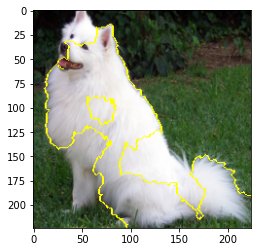

In [140]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.show()

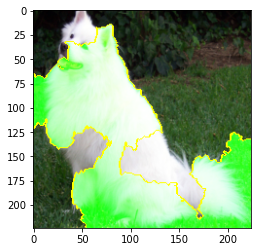

In [151]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.show()

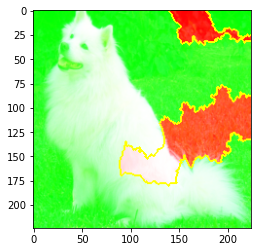

In [152]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=80, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.show()